# Moving Horizon Estimate

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit

# System parameters
d_ref = 1.0  # Target position
k_true = 2.0
b_true = 0.5
dt = 0.1
meas_noise_std = 0.05
proc_noise_std = 0.02
N = 20  # MHE window size

# Generate synthetic data via step-by-step simulation
key = jax.random.PRNGKey(42)
ts = jnp.arange(0, 10.0, dt)
n_steps = len(ts)

# State: [position, velocity], starting at rest away from target
x_true = jnp.zeros((n_steps, 2))


def simulate_step(carry, key_t):
    pos, vel = carry
    proc_noise = jax.random.normal(key_t) * proc_noise_std
    new_pos = pos + dt * vel
    new_vel = vel + dt * (-k_true * (pos - d_ref) - b_true * vel) + proc_noise
    return (new_pos, new_vel), jnp.array([new_pos, new_vel])


keys = jax.random.split(key, n_steps)
_, x_true = jax.lax.scan(simulate_step, (0.0, 0.0), keys)

# Only position is measured and velocity is hidden
meas_key = jax.random.PRNGKey(99)
meas_noise = jax.random.normal(meas_key, shape=(n_steps,)) * meas_noise_std
y_obs = x_true[:, 0] + meas_noise

print(f"Simulated {n_steps} steps. State shape: {x_true.shape}")
print(f"Observations: position only (shape {y_obs.shape})")

Simulated 100 steps. State shape: (100, 2)
Observations: position only (shape (100,))


In [2]:
def dynamics_predict(x_state, k, b):
    """Predict next state: x = [pos, vel]."""
    pos, vel = x_state[0], x_state[1]
    new_pos = pos + dt * vel
    new_vel = vel + dt * (-k * (pos - d_ref) - b * vel)
    return jnp.array([new_pos, new_vel])


def mhe_objective(
    x_states: jnp.ndarray, y_window: jnp.ndarray, k: float, b: float, rho: float
) -> float:
    """MHE objective for 2D state with position-only observations.

    x_states: (N, 2) — estimated [position, velocity] at each time step
    y_window: (N,)   — observed positions only
    """
    # Measurement error: only position is observed
    meas_error = jnp.sum((y_window - x_states[:, 0]) ** 2)

    # Dynamics penalty: enforce both position and velocity equations
    x_predicted = jax.vmap(dynamics_predict, in_axes=(0, None, None))(
        x_states[:-1], k, b
    )
    dynamics_violation = jnp.sum((x_states[1:] - x_predicted) ** 2)

    return meas_error + rho * dynamics_violation

In [ ]:
@jit
def solve_mhe(
    y_window: jnp.ndarray,
    k: float,
    b: float,
    rho: float = 100.0,
    learning_rate: float = 0.0005,
    max_iters: int = 2000,
) -> jnp.ndarray:
    """Solve MHE for a single window using gradient descent

    Returns: (N, 2) array of estimated [position, velocity].
    """
    # Initialize: position from observations, velocity from finite differences
    vel_init = jnp.concatenate([jnp.array([0.0]), (y_window[1:] - y_window[:-1]) / dt])
    x_states = jnp.stack([y_window, vel_init], axis=1)  # (N, 2)

    grad_fn = grad(mhe_objective)

    def gd_step(x_states, _):
        g = grad_fn(x_states, y_window, k, b, rho)
        x_states = x_states - learning_rate * g
        return x_states, None

    x_states, _ = jax.lax.scan(gd_step, x_states, None, length=max_iters)
    return x_states

In [ ]:
pos_est = []
vel_est = []
ts_est = []

for start in range(len(ts) - N):
    y_window = y_obs[start : start + N]
    x_states = solve_mhe(y_window, k=k_true, b=b_true)

    # Take the last state estimate as the current estimate
    pos_est.append(float(x_states[-1, 0]))
    vel_est.append(float(x_states[-1, 1]))
    ts_est.append(float(ts[start + N - 1]))

pos_est = jnp.array(pos_est)
vel_est = jnp.array(vel_est)
ts_est = jnp.array(ts_est)

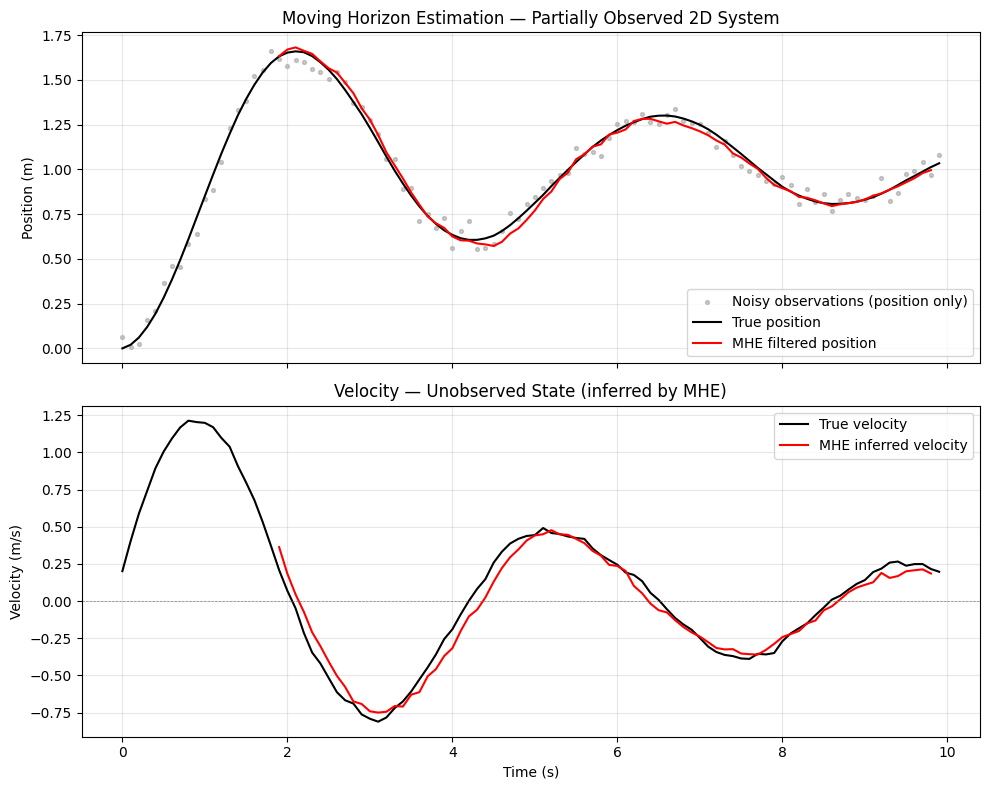

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Position subplot
ax1.scatter(
    ts, y_obs, s=8, alpha=0.4, color="gray", label="Noisy observations (position only)"
)
ax1.plot(ts, x_true[:, 0], "k-", linewidth=1.5, label="True position")
ax1.plot(ts_est, pos_est, "r-", linewidth=1.5, label="MHE filtered position")
ax1.set_ylabel("Position (m)")
ax1.set_title("Moving Horizon Estimation — Partially Observed 2D System")
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Velocity subplot — no observations available!
ax2.plot(ts, x_true[:, 1], "k-", linewidth=1.5, label="True velocity")
ax2.plot(ts_est, vel_est, "r-", linewidth=1.5, label="MHE inferred velocity")
ax2.axhline(0, color="gray", linewidth=0.5, linestyle="--")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
ax2.set_title("Velocity — Unobserved State (inferred by MHE)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()